In [1]:
!pip install tifffile
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
import pickle 
import random
from sklearn.metrics import confusion_matrix  


    100% |████████████████████████████████| 112kB 3.2MB/s 
  Running setup.py bdist_wheel for tifffile ... - \ | / - done
  Stored in directory: /root/.cache/pip/wheels/22/5b/8e/a9bc85b5dfc1cc91b840b91bfa362a11eeda847d2d4464304e
Successfully built tifffile


In [0]:
class Unet(object):
    
    ########################################################################################################################
    ########################################################################################################################
    
    #Model parameters
    height = 572
    width = 572
    num_channels = 3
    mask_channels = 1
    batch_size = 2
    learn_rate = 1e-3
    
    ########################################################################################################################
    ########################################################################################################################
    
    #variables to store training history for all iterations
    train_acc = []
    train_loss = []
    val_loss = []
    val_acc = []
    iterations = []
    
    ########################################################################################################################
    ########################################################################################################################
    
    
    #Aliasing the above lists in dictionary.
    history = {"train_acc" : train_acc,
               "train_loss" : train_loss,
               "val_loss" : val_loss,
               "val_acc" : val_acc,
               "iterations":iterations}
    
    
    ########################################################################################################################
    ########################################################################################################################
    
    #model global variables which are required to give input and get output
    sess = tf.Session() 
    optimizer = None 
    y_pred = None 
    loss = None 
    images = None
    masks = None
    learning_rate = None
    
    ########################################################################################################################
    ########################################################################################################################
    
    def __init__(self,height = 572,width =572, num_channels = 3, mask_channels = 1,batch_size=2,learn_rate = 1e-3):
        """height : Number of rows in the image. (Default = 224)
            width : Number of columns in the image. (Default = 224)
            num_channels: Number of image channels (Default = 3 (RGB))
            mask_channels : Number of channels in the mask or number of 
                            classes to be predicted. (Default = 1)
            batch_size = Batch size for mini batch training"""
        
        self.height = height
        self.width = width
        self.num_channels = num_channels
        self.mask_channels = mask_channels
        self.batch_size = batch_size
        self.learn_rate = learn_rate
        
        self.images = tf.placeholder(dtype = tf.float32, 
                        shape = [self.batch_size, self.height,self.width,self.num_channels])
    
        self.masks = tf.placeholder(dtype = tf.float32, 
                               shape = [self.batch_size,self.height,self.width,self.mask_channels])

        self.learning_rate = tf.placeholder(dtype=tf.float32,shape=[])
    
    ########################################################################################################################
    ########################################################################################################################
    
    def build_graph(self,):
        """Build the computational graph for Unet with the parameters set during initialization"""
        
        """Original unet as described in https://arxiv.org/abs/1505.04597. 
           No batch Normalization. Padding = Valid (Cropping used for concatenation)
           Image dimensions = 572x572
           Mask dimensions  = 388x388 (92 pixel context on each side. 
                                       Use mirroring for prediction of corners)"""
        
        
        #standardizing input images to 0 mean and 1 std dev
        std_images = tf.map_fn(lambda frame: tf.image.per_image_standardization(frame), self.images)
        print (std_images)
        
        #Encoder
        conv568 = self.double_conv(std_images,filters=64,kernel_size=3,strides = 1,padding="valid")
        pool284 = self.max_pool(conv568,pool_size = 2,strides = 2,padding="valid")

        conv280 = self.double_conv(pool284,filters=128,kernel_size=3,strides = 1,padding="valid")
        pool140 = self.max_pool(conv280,pool_size = 2,strides = 2,padding="valid")

        conv136 = self.double_conv(pool140,filters=256,kernel_size=3,strides = 1,padding="valid")
        pool68 = self.max_pool(conv136,pool_size = 2,strides = 2,padding="valid")

        conv64 = self.double_conv(pool68,filters=512,kernel_size=3,strides = 1,padding="valid")
        pool32 = self.max_pool(conv64,pool_size = 2,strides = 2,padding="valid")

        conv28 = self.double_conv(pool32,filters=1024,kernel_size=3,strides = 1,padding="valid")

        #Decoder
        deconv56 = self.upconv(conv28,filters=512,kernel_size=2,strides=2,padding='valid')
        skip56 = self.skip_concat(conv64,deconv56)
        conv52 = self.double_conv(skip56,filters=512,kernel_size=3,strides = 1,padding="valid")


        deconv104 = self.upconv(conv52,filters=256,kernel_size=2,strides=2,padding='valid')
        skip104= self.skip_concat(conv136,deconv104)
        conv100 = self.double_conv(skip104,filters=256,kernel_size=3,strides = 1,padding="valid")

        deconv200 = self.upconv(conv100,filters=128,kernel_size=2,strides=2,padding='valid')
        skip200 = self.skip_concat(conv280,deconv200)
        conv196 = self.double_conv(skip200,filters=128,kernel_size=3,strides = 1,padding="valid")

        deconv392 = self.upconv(conv196,filters=64,kernel_size=2,strides=2,padding='valid')
        skip392 = self.skip_concat(conv568,deconv392)
        conv388 = self.double_conv(skip392,filters=64,kernel_size=3,strides = 1,padding="valid")

        logits = tf.layers.conv2d(conv388,
                                   filters = 1,
                                   kernel_size = 1,
                                   strides = 1,
                                   padding="valid",
                                   activation= None,
                                   kernel_initializer= tf.contrib.layers.xavier_initializer())
        print(logits)
        
        self.y_pred = tf.nn.sigmoid(logits)
        print(self.y_pred)


        #loss
        self.loss = self.get_loss(self.crop_mask_to_pred_dim(self.masks,logits),logits)
        print(self.loss)

        #optimizer
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

        #Initialize the variables
        init_op = tf.global_variables_initializer()
        self.sess.run(init_op)

    ########################################################################################################################
    ########################################################################################################################
    
    def train(self,epochs,iters_in_epoch,train_images,train_masks,test_images,test_masks,
              hori_flip=False,verti_flip=False, swp_axis=False):
        """iterations : number of iterations to train.
           trian_images: Images to train the model on. Shape [num_images,height,width,num_channels]
           train_masks:  Masks for train images. Shape [num_images,height,width,mask_channels]
           test_images:  Images to evaluate the model on. Shape [num_images,height,width,num_channels]
           test_masks:   Masks for test images. Shape [num_images,height,width,mask_channels]"""
        iterations = 0
        saved_accuracy = 0
        for i in range(1,epochs+1):
            if i%11 == 0:
                self.set_learning_rate(self.learn_rate/10)
            
            
            print("epoch-------->{}".format(i))
            print("Learning Rate {}".format(self.learn_rate))
 
            for j in range(1,iters_in_epoch+1):
                iterations+=1
                if j%10 == 0 or j == 1:
                    print("iteration {}/{}".format(j,iters_in_epoch))
                    
                image_batch , mask_batch = self.batch_augment(train_images, train_masks, 
                                                              horizontal_flip= hori_flip,vertical_flip=verti_flip,
                                                              swap_axis=swp_axis)
                
                if iterations%100 == 0 or iterations == 1:
#                     print("Learning Rate {}".format(self.learn_rate))
                    self.iterations.append(iterations)
                   
                    self.sess.run(self.optimizer,{self.images:image_batch,self.masks:mask_batch,self.learning_rate:self.learn_rate})
                    
                    x = self.sess.run(self.loss,{self.images:image_batch,self.masks:mask_batch})
                    self.train_loss.append(x)
                    
                    val_image_batch , val_mask_batch = self.batch_augment(test_images, test_masks, 
                                                                     horizontal_flip= hori_flip,vertical_flip=verti_flip,
                                                                     swap_axis=swp_axis) ##########does there need to be batch augmentation in validation??
                    
                    y = self.sess.run(self.loss,{self.images:val_image_batch,self.masks:val_mask_batch})
                    self.val_loss.append(y)
                    
                    train_conf_matrix = np.zeros(shape=[2,2])
                    val_conf_matrix = np.zeros(shape=[2,2])
                    for i in range(10):
                        train_temp1 , train_temp2 = self.batch_augment(train_images[12:13], train_masks[12:13],   #only one image in train accuracy set
                                                              horizontal_flip= hori_flip,vertical_flip=verti_flip,
                                                              swap_axis=swp_axis)
                        
                        val_temp1 , val_temp2 = self.batch_augment(test_images, test_masks, 
                                                                     horizontal_flip= hori_flip,vertical_flip=verti_flip,
                                                                     swap_axis=swp_axis) ##########does there need to be batch augmentation in validation??
                        
                        train_conf_matrix += self.get_conf_matrix(train_temp1,train_temp2)
                        
                        val_conf_matrix += self.get_conf_matrix(val_temp1,val_temp2)  
                        
                    train_accuracy = train_conf_matrix[1][1]/(train_conf_matrix[0][1]+train_conf_matrix[1][0]+train_conf_matrix[1][1])
                    validation_accuracy = val_conf_matrix[1][1]/(val_conf_matrix[0][1]+val_conf_matrix[1][0]+val_conf_matrix[1][1])
                    self.train_acc.append(train_accuracy)
                    self.val_acc.append(validation_accuracy)
                    
                    print("Train_Accuracy {}, Train_loss {}".format(train_accuracy,x)) ###########code testing
                    print("Validation_Accuracy {}, Validation loss {}".format(validation_accuracy,y)) #############code testing
                    
                    
                    #if the accuracy on the validation set has increased then save the model
                    folder_id = "1Rldhx-ZSd4hAPzKg5Jo6Pny7986TmWq7"  #MMI UNET
                    filename = "saved_model.tar.gz"
                    if validation_accuracy > saved_accuracy:
                        self.save_model()
                        !tar -czvf saved_model.tar.gz saved_model
                        gdrive()
                        print (self.upload_to_google_drive(filename,folder_id))
                        saved_accuracy = validation_accuracy
                                 
                else:
                    self.sess.run(self.optimizer,{self.images:image_batch,self.masks:mask_batch,self.learning_rate:self.learn_rate})
                
        
    
    ########################################################################################################################
    ########################################################################################################################
    
    def predict_labels(self, test_images):
        """Assumes one batch is passed.
            test_images = One batch of images for which masks are to be predicted.
            Shape [batch_size,height,width,num_channels]
            returns prediction of shape [batch_size,388,388,mask_channels] and type int"""
        prediction = self.sess.run(self.y_pred,{self.images:test_images})
        prediction = (prediction >= 0.5).astype(dtype = int)   #thresholding to prob of 0.5 for required class
        
        return prediction
    
    
    ########################################################################################################################
    ########################################################################################################################
    
    def get_conf_matrix(self,test_images, test_masks):
        """This function returns the confustion matrix for predictions on the test_images
            of the current model on CROPPED mask. 
            Assumes one batch is passed.
            test_images: Images to test the model on. Shape [batch_size,height,width,num_channels]
            test_masks:  Masks for test images. Shape [batch_size,height,width,mask_channels]
            test_masks is centre cropped to the prediction dimension of the model(currently 388x388)"""
        conf_matrix = np.zeros(shape=[2,2])
        test_masks = test_masks.astype(dtype=int)
        prediction = self.predict_labels(test_images)
        start =  (test_masks.shape[1] - prediction.shape[1])//2
        offset = prediction.shape[1]
        test_masks = test_masks[:,start:start+offset,start:start+offset,:]
        
        
        prediction = prediction.flatten()
        test_masks = test_masks.flatten()
        
        conf_matrix += confusion_matrix(test_masks,prediction)    
                
        return conf_matrix
    
    ########################################################################################################################
    ########################################################################################################################
    
    def get_accuracy(self,test_images,test_masks):
        """This function gives the accuracy for predictions on the test_images
            of the current model on CROPPED mask. 
            Accuracy is defined as the mean IoU.
            Assumes one batch is passed.
            test_images: Images to test the model on. Shape [batch_size,height,width,num_channels]
            test_masks:  Masks for test images. Shape [batch_size,height,width,mask_channels]
            test_masks is centre cropped to the prediction dimension of the model(currently 388x388)"""
        conf_matrix = self.get_conf_matrix(test_images,test_masks)
        
        return conf_matrix[1][1]/(conf_matrix[0][1]+conf_matrix[1][0]+conf_matrix[1][1])
    
    ########################################################################################################################
    ########################################################################################################################
    
    
    def plot_accuracies(self):
        plt.plot(self.iterations,self.train_acc, color='red', label='Training Accuracy')
        plt.plot(self.iterations,self.val_acc, color='blue', label='Validation Accuracy')
        plt.xlabel('Number Of Iterations')
        plt.ylabel('Mean IoU/Jaccard Coefficient')
        plt.legend()
        plt.show()
    
    ########################################################################################################################
    ########################################################################################################################
    
    def plot_losses(self):
        plt.plot(self.iterations,self.train_loss, color='red', label='Training Loss')
        plt.plot(self.iterations,self.val_loss, color='blue', label='Validation Loss')
        plt.xlabel('Number Of Iterations')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
    
    
    ########################################################################################################################
    ########################################################################################################################
    
    
    def plot_history():
        self.plot_accuracies()
        self.plot_losses()
    
    ########################################################################################################################
    ########################################################################################################################
    
    def show_prediction(self,image):
        """ Plots the image and the predicted mask for the image.
            image: An image of shape [height, width, num_channels].
        """
        #plot the image
        matrix = image
        #scale the image color channels between 0 and 1
        w, h, d = matrix.shape
        matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)
        # Get 2nd and 98th percentile
        mins = np.percentile(matrix, 1, axis=0)
        maxs = np.percentile(matrix, 99, axis=0) - mins
        matrix = (matrix - mins[None, :]) / maxs[None, :]
        matrix = np.reshape(matrix, [w, h, d])
        matrix = matrix.clip(0, 1)

        
        #predict mask and plot the same
        image_batch = np.stack([image]*self.batch_size)
        prediction = self.predict_labels(image_batch)[0].astype(np.uint8)
        tiff.imshow(255 * np.stack([prediction, prediction, prediction]))
        
        start = (matrix.shape[0] - prediction.shape[0])//2
        offset = prediction.shape[0]
        tiff.imshow(255*matrix[start:start+offset,start:start+offset,:])
        
    ########################################################################################################################
    ########################################################################################################################    
    
    def overlay_prediction(self, image):
        pass
    
    ########################################################################################################################
    ########################################################################################################################
    
    def get_history(self):
        pass
        ##need to make deep copy of the dictionary and the list inside the dict
    
        
    
    ########################################################################################################################
    ########################################################################################################################
    
    def get_loss(self,y_true,y_pred):
        """Which loss function to use"""
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true,logits=y_pred)
        loss = tf.reduce_mean(loss)
        return loss
    
    ########################################################################################################################
    ########################################################################################################################
    
    def get_batch(self,images,masks):
        """images is 4D np array of shape [num_images,height,width,num_channels]
           masks is 4D np array of shape [num_images,height,width,mask_channels].
        """
        x_batch = np.zeros((self.batch_size,self.height,self.width,self.num_channels))
        y_batch = np.zeros((self.batch_size,self.height,self.width,self.mask_channels))
        images_height = images.shape[1]
        images_width = images.shape[2]
        
        for i in range(self.batch_size):
            random_width = random.randint(0, images_width - self.width - 1)
            random_height = random.randint(0, images_height - self.height - 1)
            random_image = random.randint(0, images.shape[0] - 1)

            y_batch[i] = np.array(masks[random_image,
                                        random_height: random_height + self.height,
                                        random_width: random_width + self.width,:])
            x_batch[i] = np.array(images[random_image,
                                         random_height: random_height + self.height,
                                         random_width: random_width + self.width,:])
        return x_batch, y_batch

    ########################################################################################################################
    ########################################################################################################################

    def batch_augment(self,images, masks, horizontal_flip=False,
                      vertical_flip=False, swap_axis=False):
        X = images
        y = masks
        X_batch, y_batch = self.get_batch(X, y)

        for i in range(X_batch.shape[0]):
            xb = X_batch[i]
            yb = y_batch[i]

            if horizontal_flip:
                if np.random.random() < 0.5:
                    xb = flip_axis(xb, 0)
                    yb = flip_axis(yb, 0)

            if vertical_flip:
                if np.random.random() < 0.5:
                    xb = flip_axis(xb, 1)
                    yb = flip_axis(yb, 1)

            if swap_axis:
                if np.random.random() < 0.5:
                    xb = xb.swapaxes(0, 1)
                    yb = yb.swapaxes(0, 1)

            X_batch[i] = xb
            y_batch[i] = yb

        return X_batch, y_batch
    
    ########################################################################################################################
    ########################################################################################################################
    
    def squeeze_excite(self,conv,ratio=16,show_tensor=True):
        channels = conv.get_shape().as_list()[3]
        height = conv.get_shape().as_list()[1]
        width = conv.get_shape().as_list()[2]
        
        x = tf.reduce_mean(conv,axis=1)
        x = tf.reduce_mean(x,axis = 1)
        
        x = tf.layers.dense(x,
                        units=channels//ratio,
                        activation=tf.nn.relu,
                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        x = tf.layers.dense(x,
                        units=channels,
                        activation=tf.nn.sigmoid,
                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        
        x=tf.expand_dims(x,axis=1)
        x=tf.expand_dims(x,axis=1)
        x = tf.tile(x,multiples=[1,height,width,1])
        
        x = tf.multiply(conv, x)
        
        if show_tensor:
            print(x)
            
        return x
        
        
    ########################################################################################################################
    ########################################################################################################################
        
        
    def double_conv(self,inputs,filters,kernel_size,strides = 1,padding="valid",show_tensor = True):
        conv1 = tf.layers.conv2d(inputs,
                               filters = filters,
                               kernel_size = kernel_size,
                               strides = strides,
                               padding=padding,
                               activation= tf.nn.relu,
                               kernel_initializer= tf.contrib.layers.xavier_initializer())
#         conv1 = self.squeeze_excite(conv1)
        conv1 = tf.layers.batch_normalization(conv1,training=True)
        
        if show_tensor:
            print(conv1)
        conv2 = tf.layers.conv2d(conv1,
                               filters = filters,
                               kernel_size = kernel_size,
                               strides = strides,
                               padding=padding,
                               activation= tf.nn.relu,
                               kernel_initializer= tf.contrib.layers.xavier_initializer())
        conv2 = self.squeeze_excite(conv2)
        conv2 = tf.layers.batch_normalization(conv2,training=True)
    
        if show_tensor:    
            print(conv2)

        return conv2

    ########################################################################################################################
    ########################################################################################################################
    
    def max_pool(self,inputs,pool_size = 2,strides = 2,padding="valid",show_tensor = True):
        pool = tf.layers.max_pooling2d(inputs,pool_size = pool_size,strides = strides,padding=padding)
        if show_tensor:
            print(pool)
        return pool
    
    
    ########################################################################################################################
    ########################################################################################################################

    def upconv(self,inputs,filters=512,kernel_size=2,strides=2,padding='valid',show_tensor = True):
        deconv = tf.layers.conv2d_transpose(inputs,
                                          filters=filters,
                                          kernel_size=kernel_size,
                                          strides=strides,  
                                          padding=padding,
                                          activation=tf.nn.relu,
                                          kernel_initializer=tf.contrib.layers.xavier_initializer())
        if show_tensor:
            print(deconv)
        return deconv

    
    
    ########################################################################################################################
    ########################################################################################################################
    
    
    def skip_concat(self,encoder_skip,decoder_skip,show_tensor = True):
        """Dimension of encoder_skip is assumed to be greater than dimension of decoder_skip
           and their difference is assumed to be divisible by 2"""
        dim_encoder = encoder_skip.get_shape().as_list()[1]
        dim_decoder = decoder_skip.get_shape().as_list()[1]
        difference = dim_encoder - dim_decoder
        start = difference//2   
        crop_encoder = tf.image.crop_to_bounding_box(encoder_skip,
                                                     start,
                                                     start,
                                                     dim_decoder,
                                                     dim_decoder)

        skip = tf.concat([crop_encoder,decoder_skip], axis = -1)
        if show_tensor:
            print(skip)

        return skip

    
    ########################################################################################################################
    ########################################################################################################################
    
    
    
    def crop_mask_to_pred_dim(self,mask,pred):
        dim_mask = mask.get_shape().as_list()[1]
        dim_pred = pred.get_shape().as_list()[1]
        difference = dim_mask - dim_pred
        start = difference//2   
        crop_mask = tf.image.crop_to_bounding_box(mask,
                                                     start,
                                                     start,
                                                     dim_pred,
                                                     dim_pred)
        return crop_mask
    
    ########################################################################################################################
    ########################################################################################################################
    
    
    def save_model(self):
        """Saves the variable values for the current model
           Assumes directory????"""
        !mkdir saved_model ####################################################### is this call allowed??
        saver = tf.train.Saver()
        path = saver.save(self.sess,"./saved_model/model.ckpt")
        print ("Model saved @ " + path)
        return path
    
    ########################################################################################################################
    ########################################################################################################################
    
    
    def restore_model(self):
        """This function restores a previously saved model
           Assumes directory???"""
        saver = tf.train.Saver()
        saver.restore(self.sess, "./saved_model/model.ckpt")
    
    
    
    ########################################################################################################################
    ########################################################################################################################
    
    
    def restore_model_from_drive(self,file_id):
        downloaded = drive.CreateFile({'id': file_id})
        downloaded.GetContentFile("saved_model.tar.gz")
        !tar -xzvf saved_model.tar.gz
        self.restore_model()
    
    ########################################################################################################################
    ########################################################################################################################
    
        
    def upload_to_google_drive(self,filename,folder_id):
        uploaded = False
        file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
        try:
            for file1 in file_list:
                if (file1['title'] == filename) and (not uploaded):
                    file1.Delete()
                    f = drive.CreateFile({"parents": [{"kind": "drive#fileLink", "id": folder_id, }]})
                    f.SetContentFile(filename)
                    f.Upload()
                    uploaded = True
            if not uploaded:
                f = drive.CreateFile({"parents": [{"kind": "drive#fileLink", "id": folder_id, }]})
                f.SetContentFile(filename)
                f.Upload()
                uploaded = True
        except:
            print ("Failed")

        return f.get("id")
    
    ########################################################################################################################
    ########################################################################################################################
    
    def set_learning_rate(self,lr):
        self.learn_rate = lr
    
    ########################################################################################################################
    ########################################################################################################################
    
 

In [0]:
# downloading and loading images
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def gdrive():
    global drive
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

In [4]:
downloaded = drive.CreateFile({'id': "1rn57fUA65UKGkPTu2-qz4fvxCxlk1Vko"})
downloaded.GetContentFile("dstl_images.pkl")
print("Dstl_images")
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({'id': "1wSjqp_HsIulyeW87qHKaBF8RaD6tgDeY"})
downloaded.GetContentFile("dstl_masks_1.pkl")
print("Dstl_masks")

Dstl_images
Dstl_masks


In [5]:
model = Unet(height = 572,width = 572, num_channels = 3, 
             mask_channels = 1, batch_size = 4,learn_rate=1e-4)
model.build_graph()
with open("dstl_images.pkl","rb") as f:
    dstl_images = pickle.load(f)
with open("dstl_masks_1.pkl","rb") as f:
    dstl_masks = pickle.load(f)
    
size_x = float("inf")
size_y = float("inf")


for i in range(len(dstl_images)):
    if dstl_images[i].shape[0] < size_x:
        size_x = dstl_images[i].shape[0]
    if dstl_images[i].shape[1] < size_y:
        size_y = dstl_images[i].shape[1]
        
print (size_x)
print (size_y)

for i in range(len(dstl_images)):
    dstl_images[i] = dstl_images[i][:size_x,:size_y,:]
    dstl_masks[i] = dstl_masks[i][:size_x,:size_y]
    
dstl_images = np.stack(dstl_images,axis = 0)
print(dstl_images.shape)
dstl_masks = np.stack(dstl_masks,axis = 0)
dstl_masks = np.expand_dims(dstl_masks,axis = -1)
print(dstl_masks.shape)

model.train(epochs = 10,iters_in_epoch = 1000,
            train_images = np.delete(dstl_images,10,axis=0),
            train_masks =  np.delete(dstl_masks,10,axis=0),
            test_images = dstl_images[10:11],
            test_masks = dstl_masks[10:11],
            hori_flip=False,verti_flip=False, swp_axis=False)  

Tensor("map/TensorArrayStack/TensorArrayGatherV3:0", shape=(4, 572, 572, 3), dtype=float32)
Tensor("batch_normalization/FusedBatchNorm:0", shape=(4, 570, 570, 64), dtype=float32)
Tensor("Mul:0", shape=(4, 568, 568, 64), dtype=float32)
Tensor("batch_normalization_1/FusedBatchNorm:0", shape=(4, 568, 568, 64), dtype=float32)
Tensor("max_pooling2d/MaxPool:0", shape=(4, 284, 284, 64), dtype=float32)
Tensor("batch_normalization_2/FusedBatchNorm:0", shape=(4, 282, 282, 128), dtype=float32)
Tensor("Mul_1:0", shape=(4, 280, 280, 128), dtype=float32)
Tensor("batch_normalization_3/FusedBatchNorm:0", shape=(4, 280, 280, 128), dtype=float32)
Tensor("max_pooling2d_1/MaxPool:0", shape=(4, 140, 140, 128), dtype=float32)
Tensor("batch_normalization_4/FusedBatchNorm:0", shape=(4, 138, 138, 256), dtype=float32)
Tensor("Mul_2:0", shape=(4, 136, 136, 256), dtype=float32)
Tensor("batch_normalization_5/FusedBatchNorm:0", shape=(4, 136, 136, 256), dtype=float32)
Tensor("max_pooling2d_2/MaxPool:0", shape=(4, 6

In [0]:
model.plot_accuracies()
model.plot_losses()

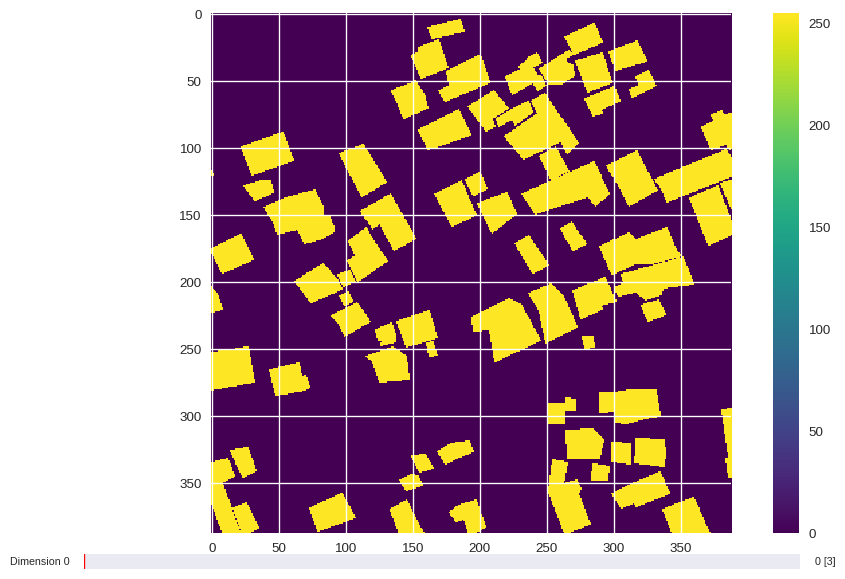

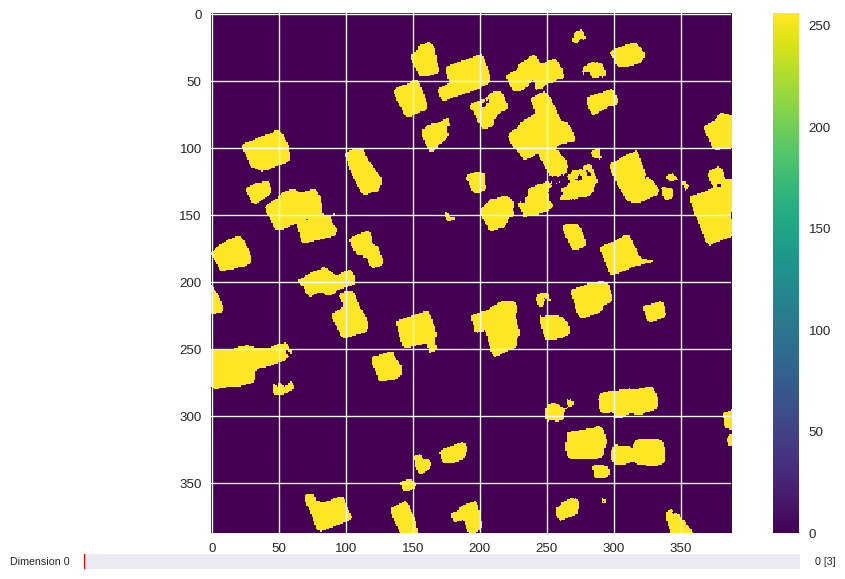

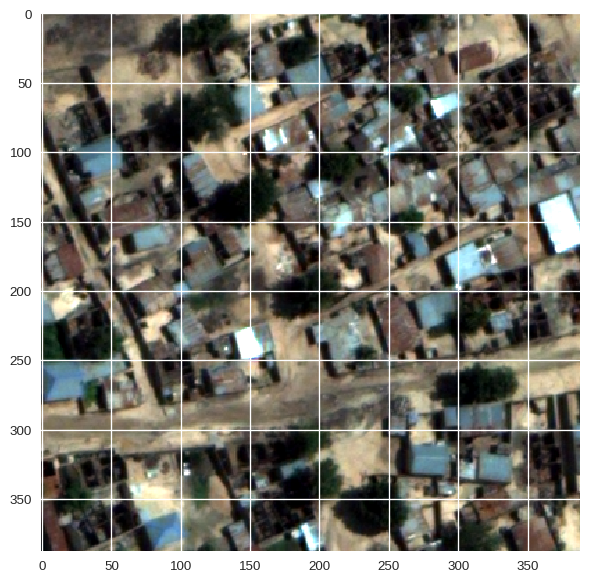

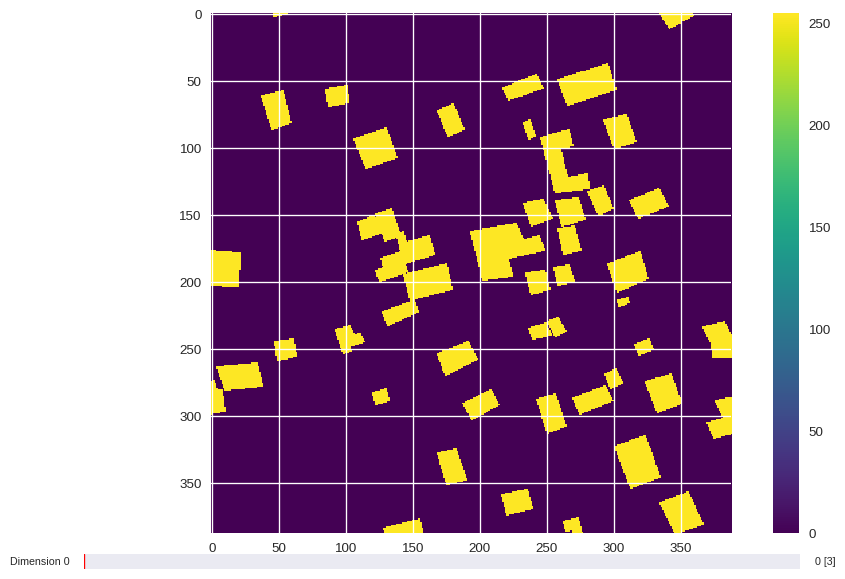

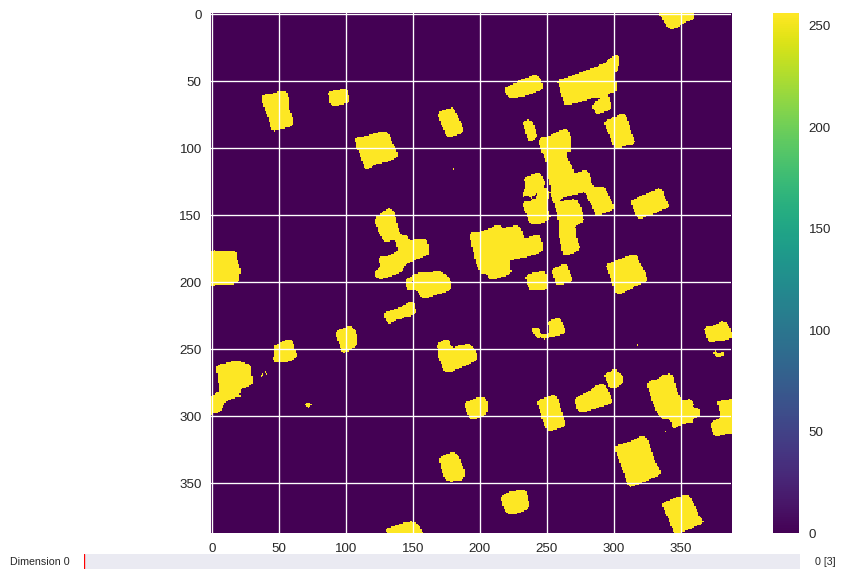

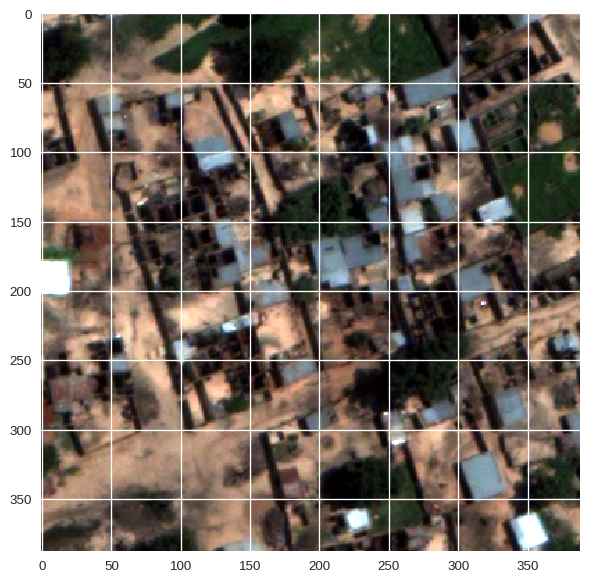

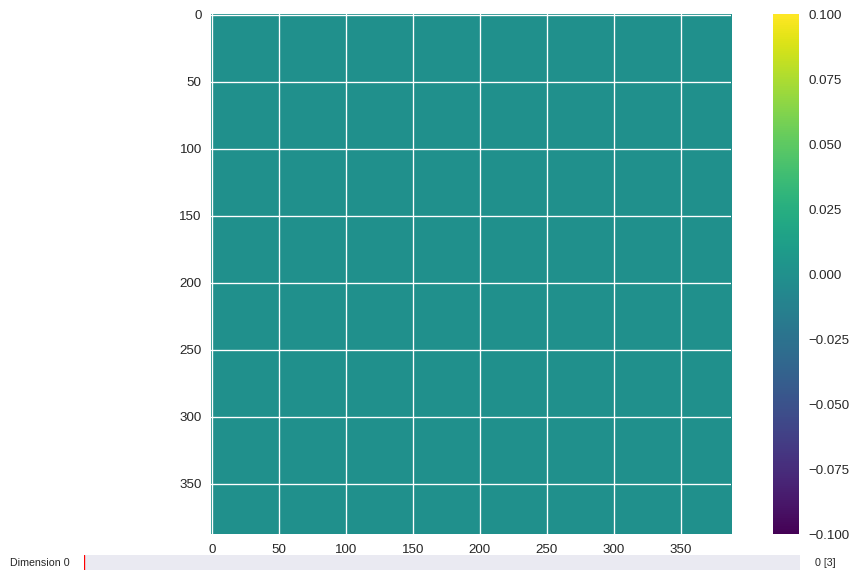

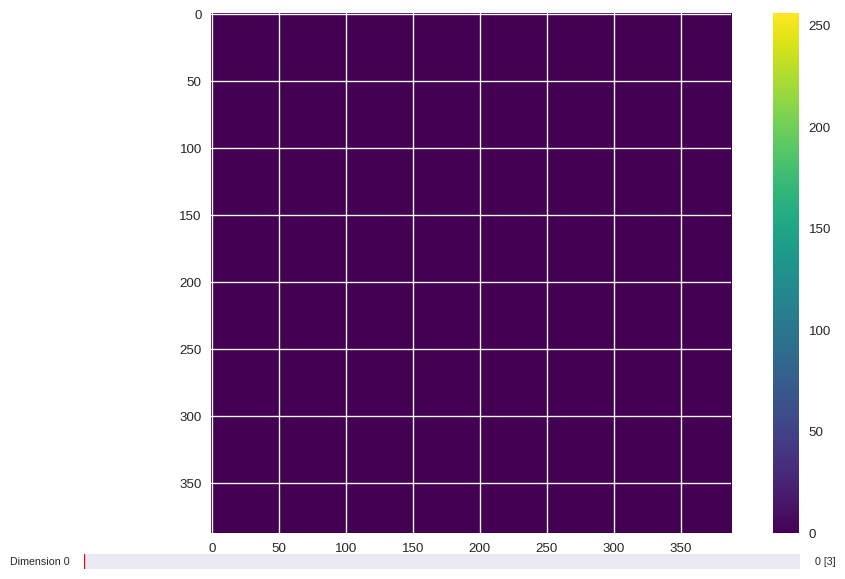

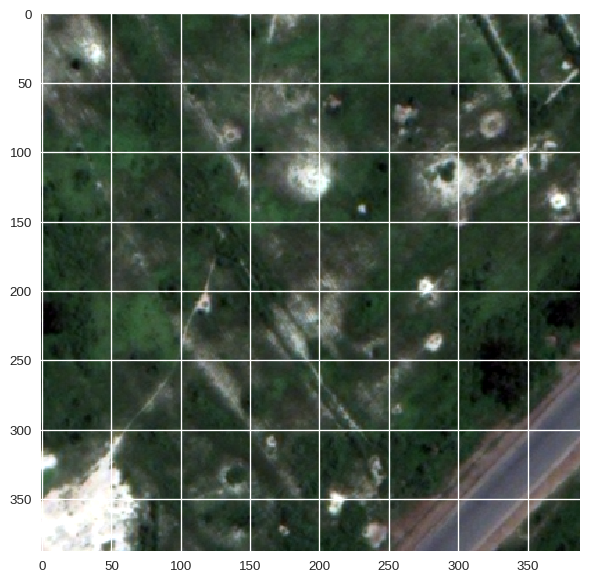

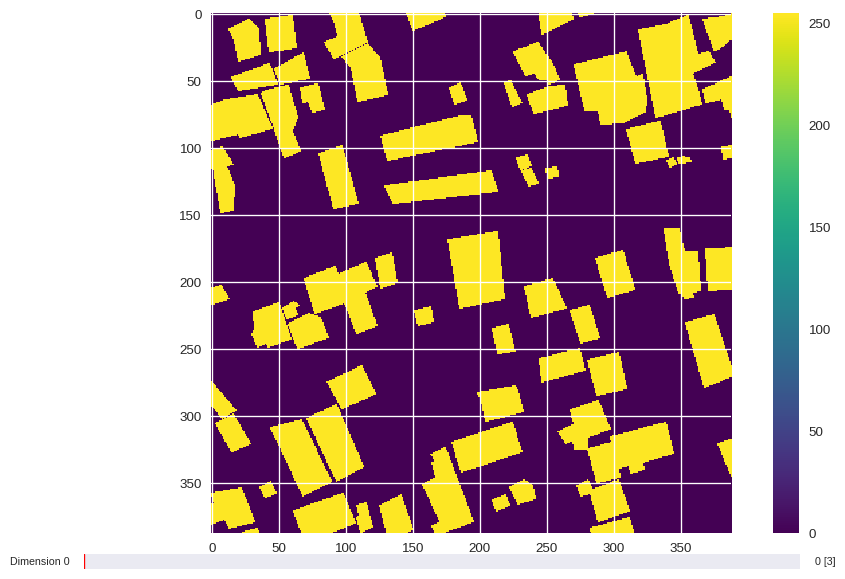

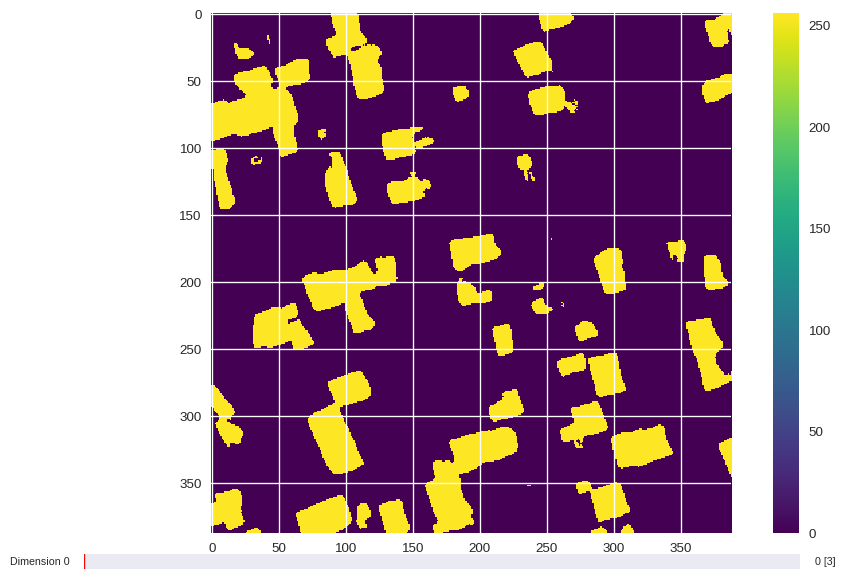

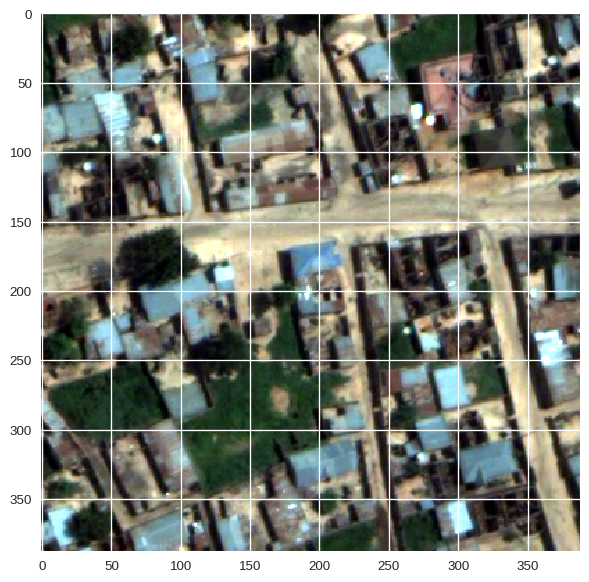

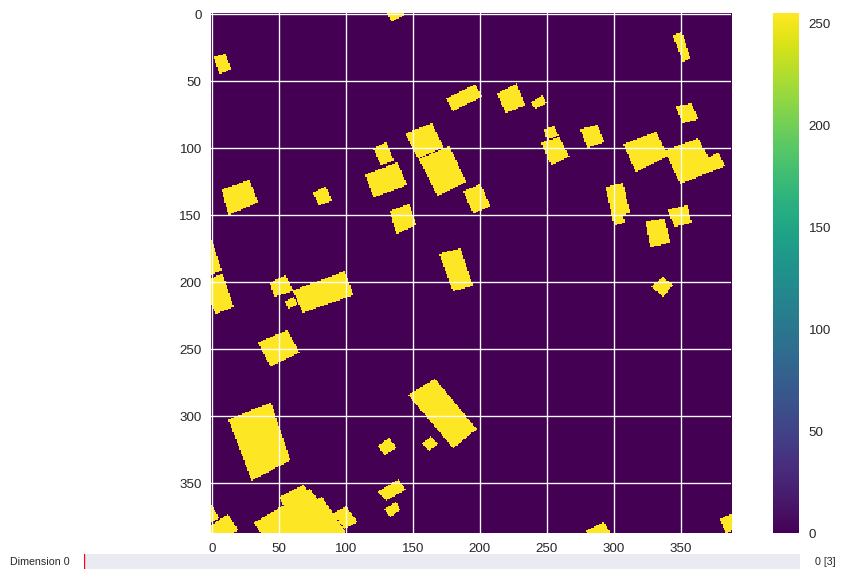

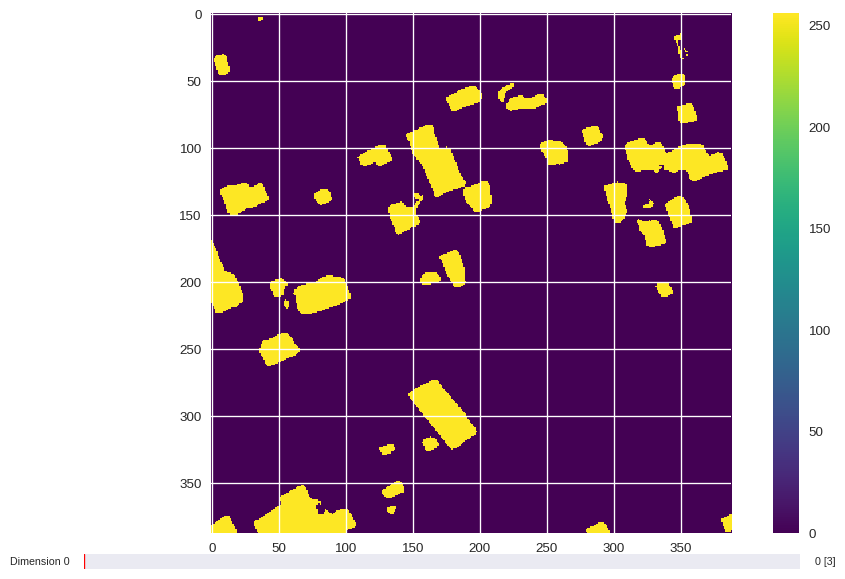

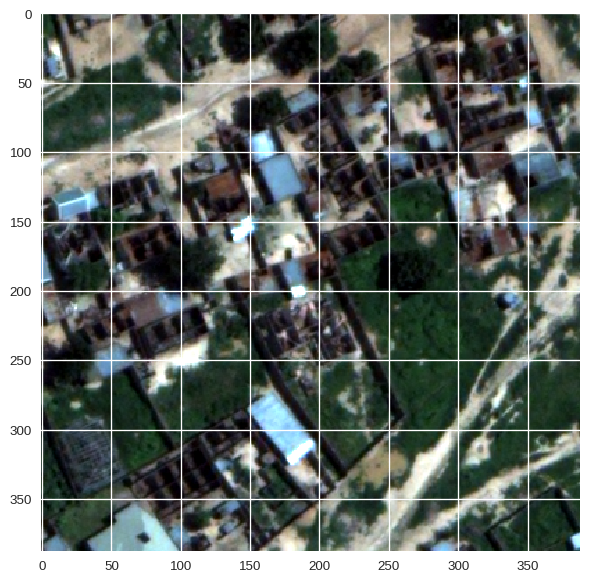

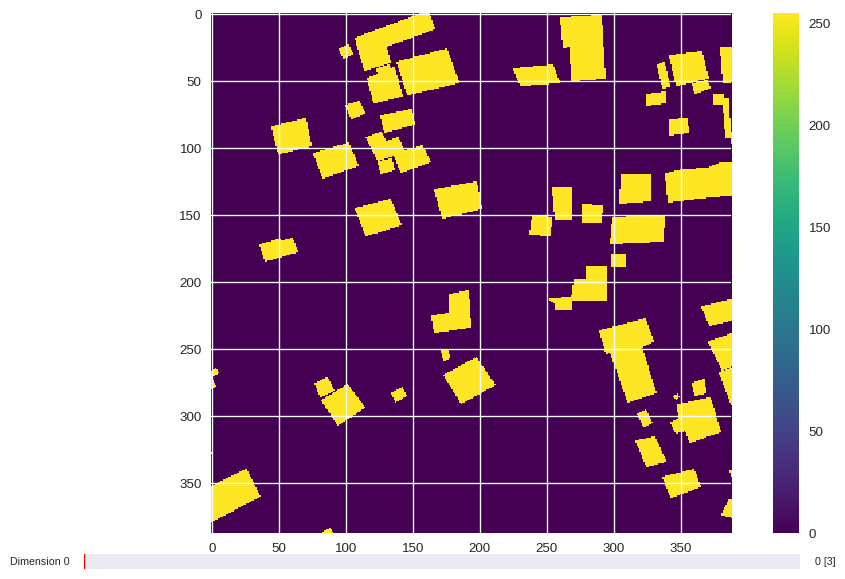

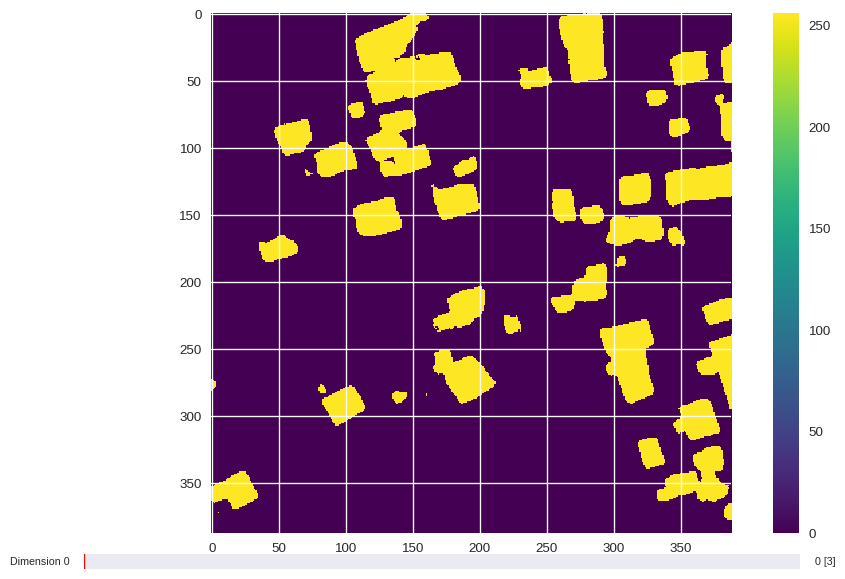

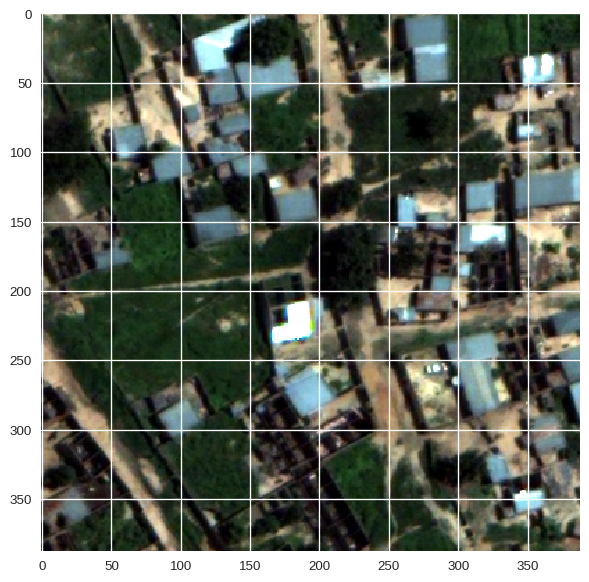

In [15]:
for j in range(2):
    a,c = model.get_batch(dstl_images[10:11],dstl_masks[10:11])
    b = model.predict_labels(a)
    for i in range(3):
        tiff.imshow(255*np.stack([c[i][92:480,92:480,:],c[i][92:480,92:480,:],c[i][92:480,92:480,:]]))
        model.show_prediction(a[i])
    